python draw_c1_DTB.py
-------draw_finish----------
-------draw_finish----------
-------draw_finish----------
-------draw_finish----------


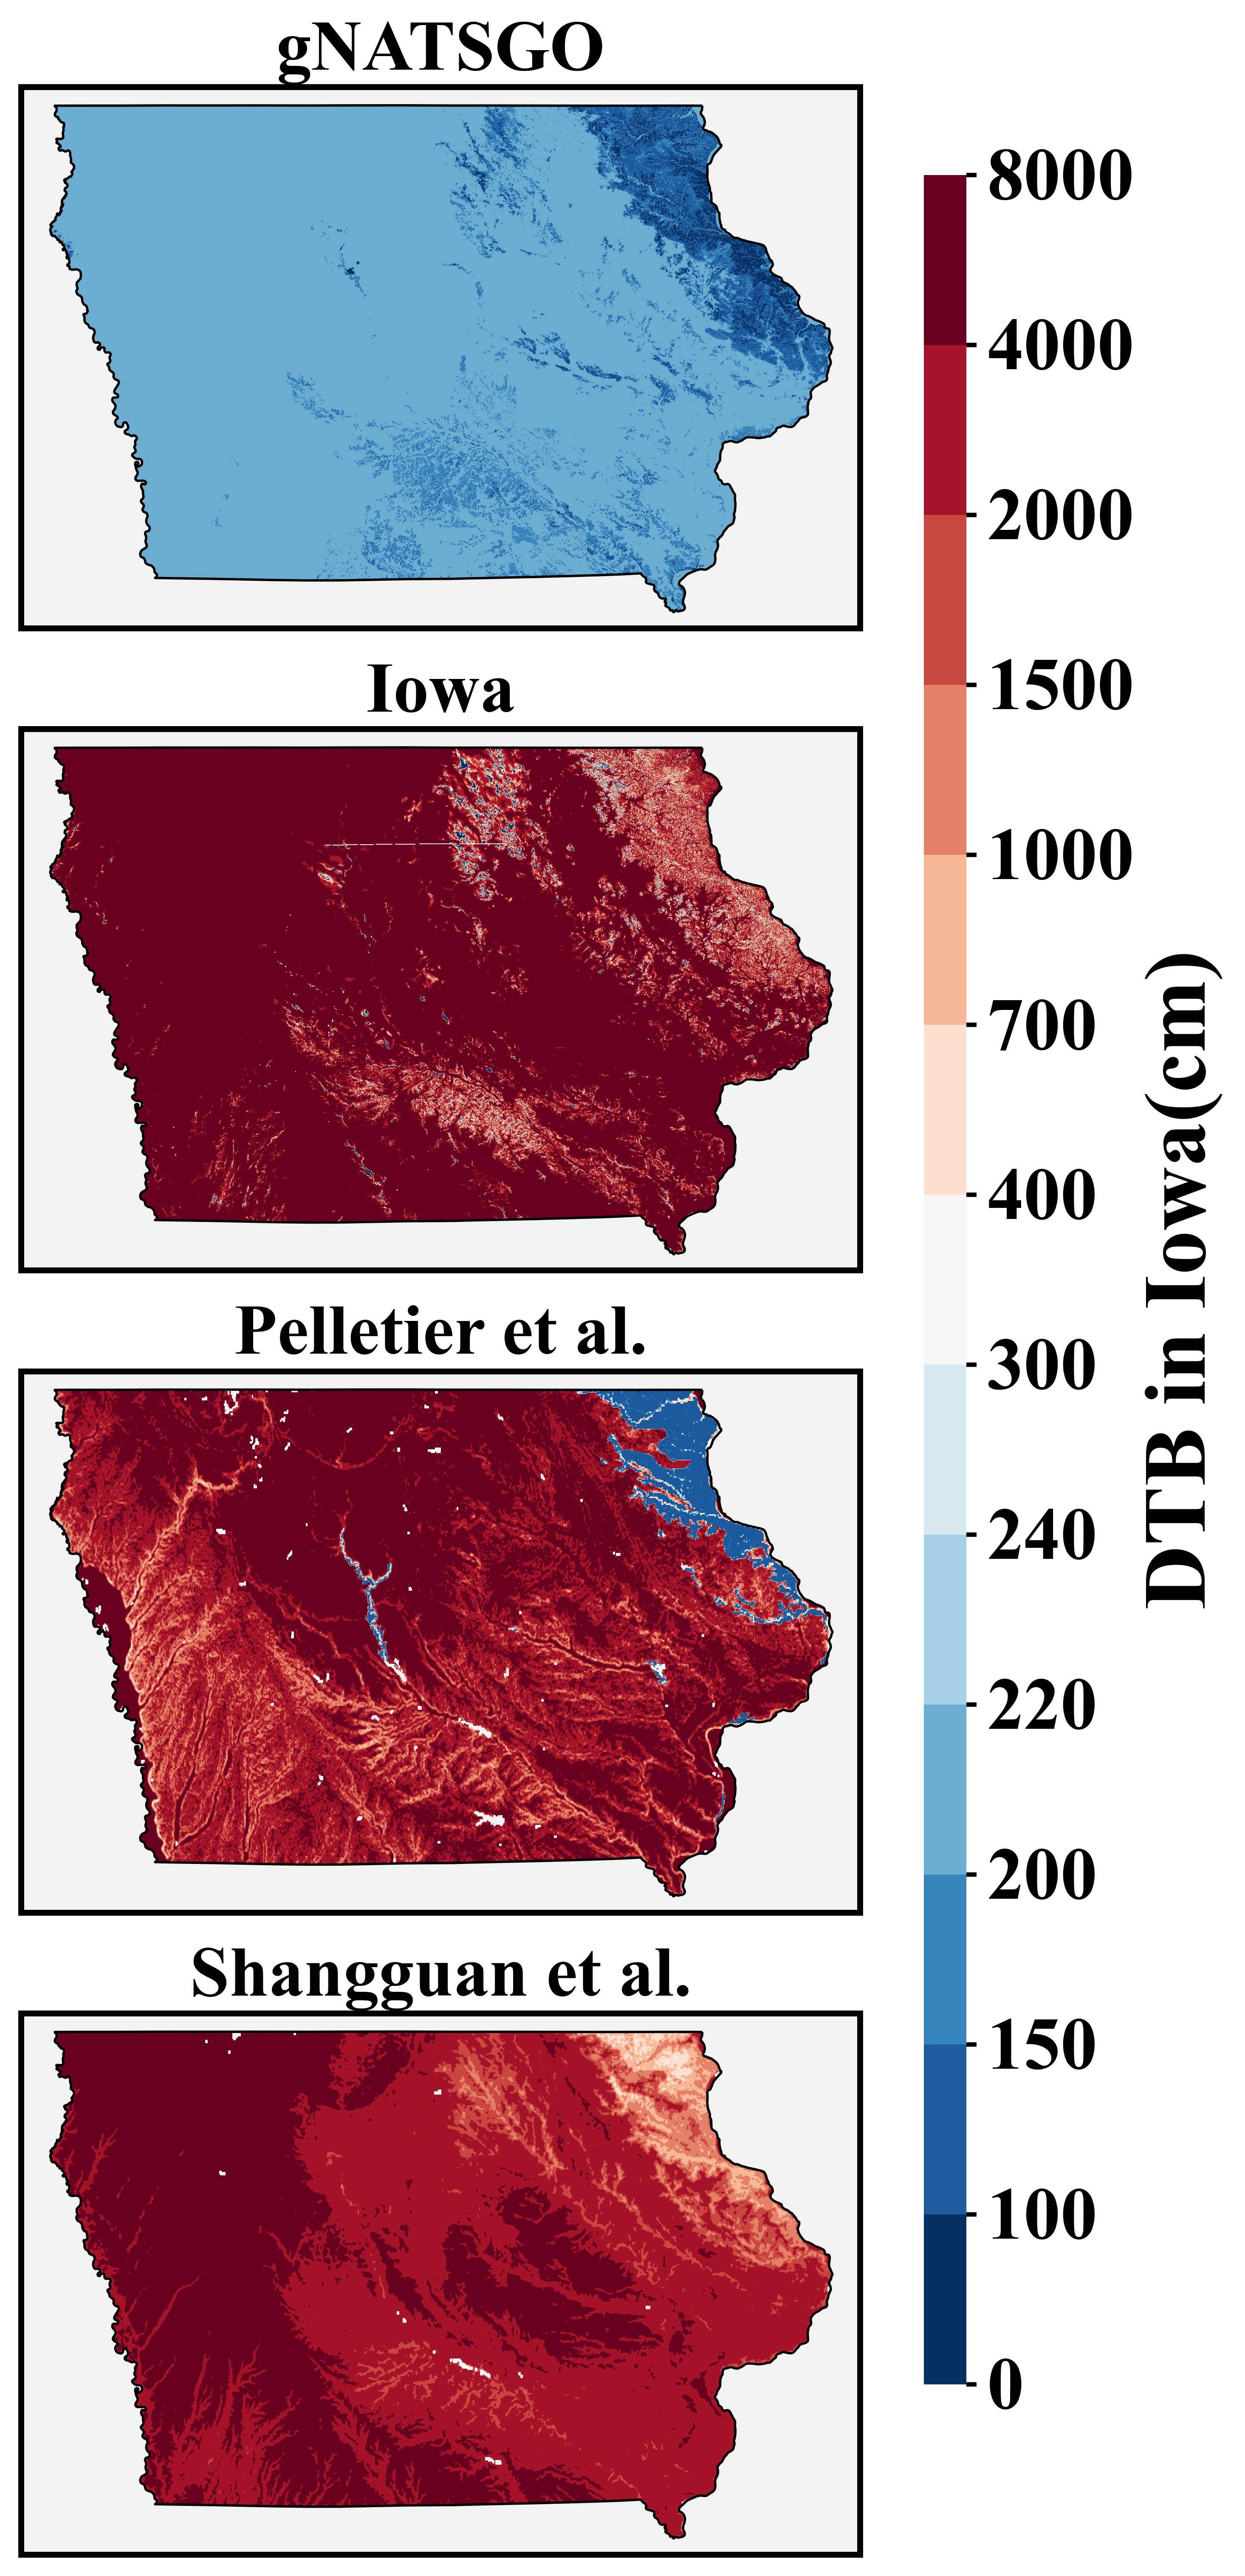

In [ ]:
%matplotlib inline

import os
import cmaps
import salem
import numpy as np
import xarray as xr
import geopandas as gpd
from pylab import rcParams
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from myfunc import timer
from myfunc import DirMan
import config
import matplotlib.font_manager as fm

resolution     = config.resolution
region         = config.region
data_path      = config.data_path
post_data_path = config.post_data_path
shp_path       = config.shp_path
fig_path       = config.fig_path

print('python draw_c1_DTB.py')

font = {'family': 'Times New Roman'}
matplotlib.rc('font', **font)

params = {'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

path = '/tera11/zhwei/students/Xionghui/data/DTB/'

shp = gpd.read_file(shp_path+'US/States/Iowa.shp')

level = [0, 100, 150, 200, 220, 240, 300, 400, 700, 1000, 1500, 2000, 4000, 8000]

cmap = 'RdBu_r'

font_properties = fm.FontProperties(weight='bold')

fig = plt.figure(figsize=(5, 13), dpi=500)
fig.subplots_adjust(left=0.05, right=0.84, 
                bottom=0.02, top=0.95, hspace=0, wspace=0.05) 
gs = GridSpec(4, 1)

test = xr.open_dataset(f'{post_data_path}DTB/Iowa/Iowa.nc')
lat = test['lat']
lon = test['lon']
xmin,xmax,ymin,ymax = lon.min(),lon.max(),lat.min(),lat.max()
test.close()

def define_colormap(level, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    color = cmap(np.linspace(0, 1, len(level) - 1))
    cmap_custom = colors.ListedColormap(color)
    cmap_custom.set_under(cmap(0))
    cmap_custom.set_over(color[-1])
    norm = colors.BoundaryNorm(level, cmap_custom.N)
    return cmap_custom, norm

cmap, norm= define_colormap(level,cmap)

def plot(ax, s, name, xmin, xmax, ymin, ymax):
    s = np.ma.masked_where(np.isnan(s), s)  
    
    shp_fixed = shp.copy()
    shp_fixed['geometry'] = shp_fixed['geometry'].buffer(0)
    
    img = ax.imshow(s, cmap=cmap,
                    extent=[xmin, xmax, ymax, ymin],
                    norm = norm)
    
    bbox = gpd.GeoSeries([box(xmin, ymin, xmax, ymax)], crs=shp.crs)
    clipped_shapefile = gpd.clip(shp, bbox)
    clipped_shapefile.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=0.8)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(2)  

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(name,fontsize=24,fontweight='bold')
    
    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    # ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent([xmin,xmax,ymin,ymax])
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    print('-------draw_finish----------')
    return img


def draw1():
    image = xr.open_dataset(f'{post_data_path}DTB/gNATSGO/Bedrock_US_gNATSGO_90m-2.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'gNATSGO'
    img = plot(fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

def draw2():
    image = xr.open_dataset(f'{post_data_path}DTB/Iowa/Iowa.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'Iowa'
    img = plot(fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

def draw3():
    image = xr.open_dataset(f'{post_data_path}mask1/mask1_v3/DTB_temp1.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'Pelletier et al.'
    img = plot(fig.add_subplot(gs[2, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img


def draw4():
    image = xr.open_dataset(f'{post_data_path}mask1/mask1_v1/DTB_temp2.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'Shangguan et al.'
    img = plot(fig.add_subplot(gs[3, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

draw1()
draw2()
draw3()
img = draw4()

rect = [0.9, 0.1, 0.04, 0.8]  #左下角x,y,宽,高
cbar_ax = fig.add_axes(rect,frameon = False)
cb = fig.colorbar(img, 
                drawedges=False,
                ticks=level, 
                cax=cbar_ax, 
                orientation='vertical',
                spacing='uniform')

cb.ax.tick_params(labelsize=20)
cb.ax.yaxis.set_tick_params(direction='out', width=1.5)
for label in cb.ax.get_xticklabels() + cb.ax.get_yticklabels():
    label.set_fontproperties(font_properties)
cb.set_label(f"DTB in Iowa(cm)", fontsize=30, fontweight='bold')

# plt.tight_layout()
# plt.savefig(f"{fig_path}/c1_DTB.png")
plt.show()

python draw_c1_DTB.py
-------draw_finish----------
-------draw_finish----------
-------draw_finish----------
-------draw_finish----------


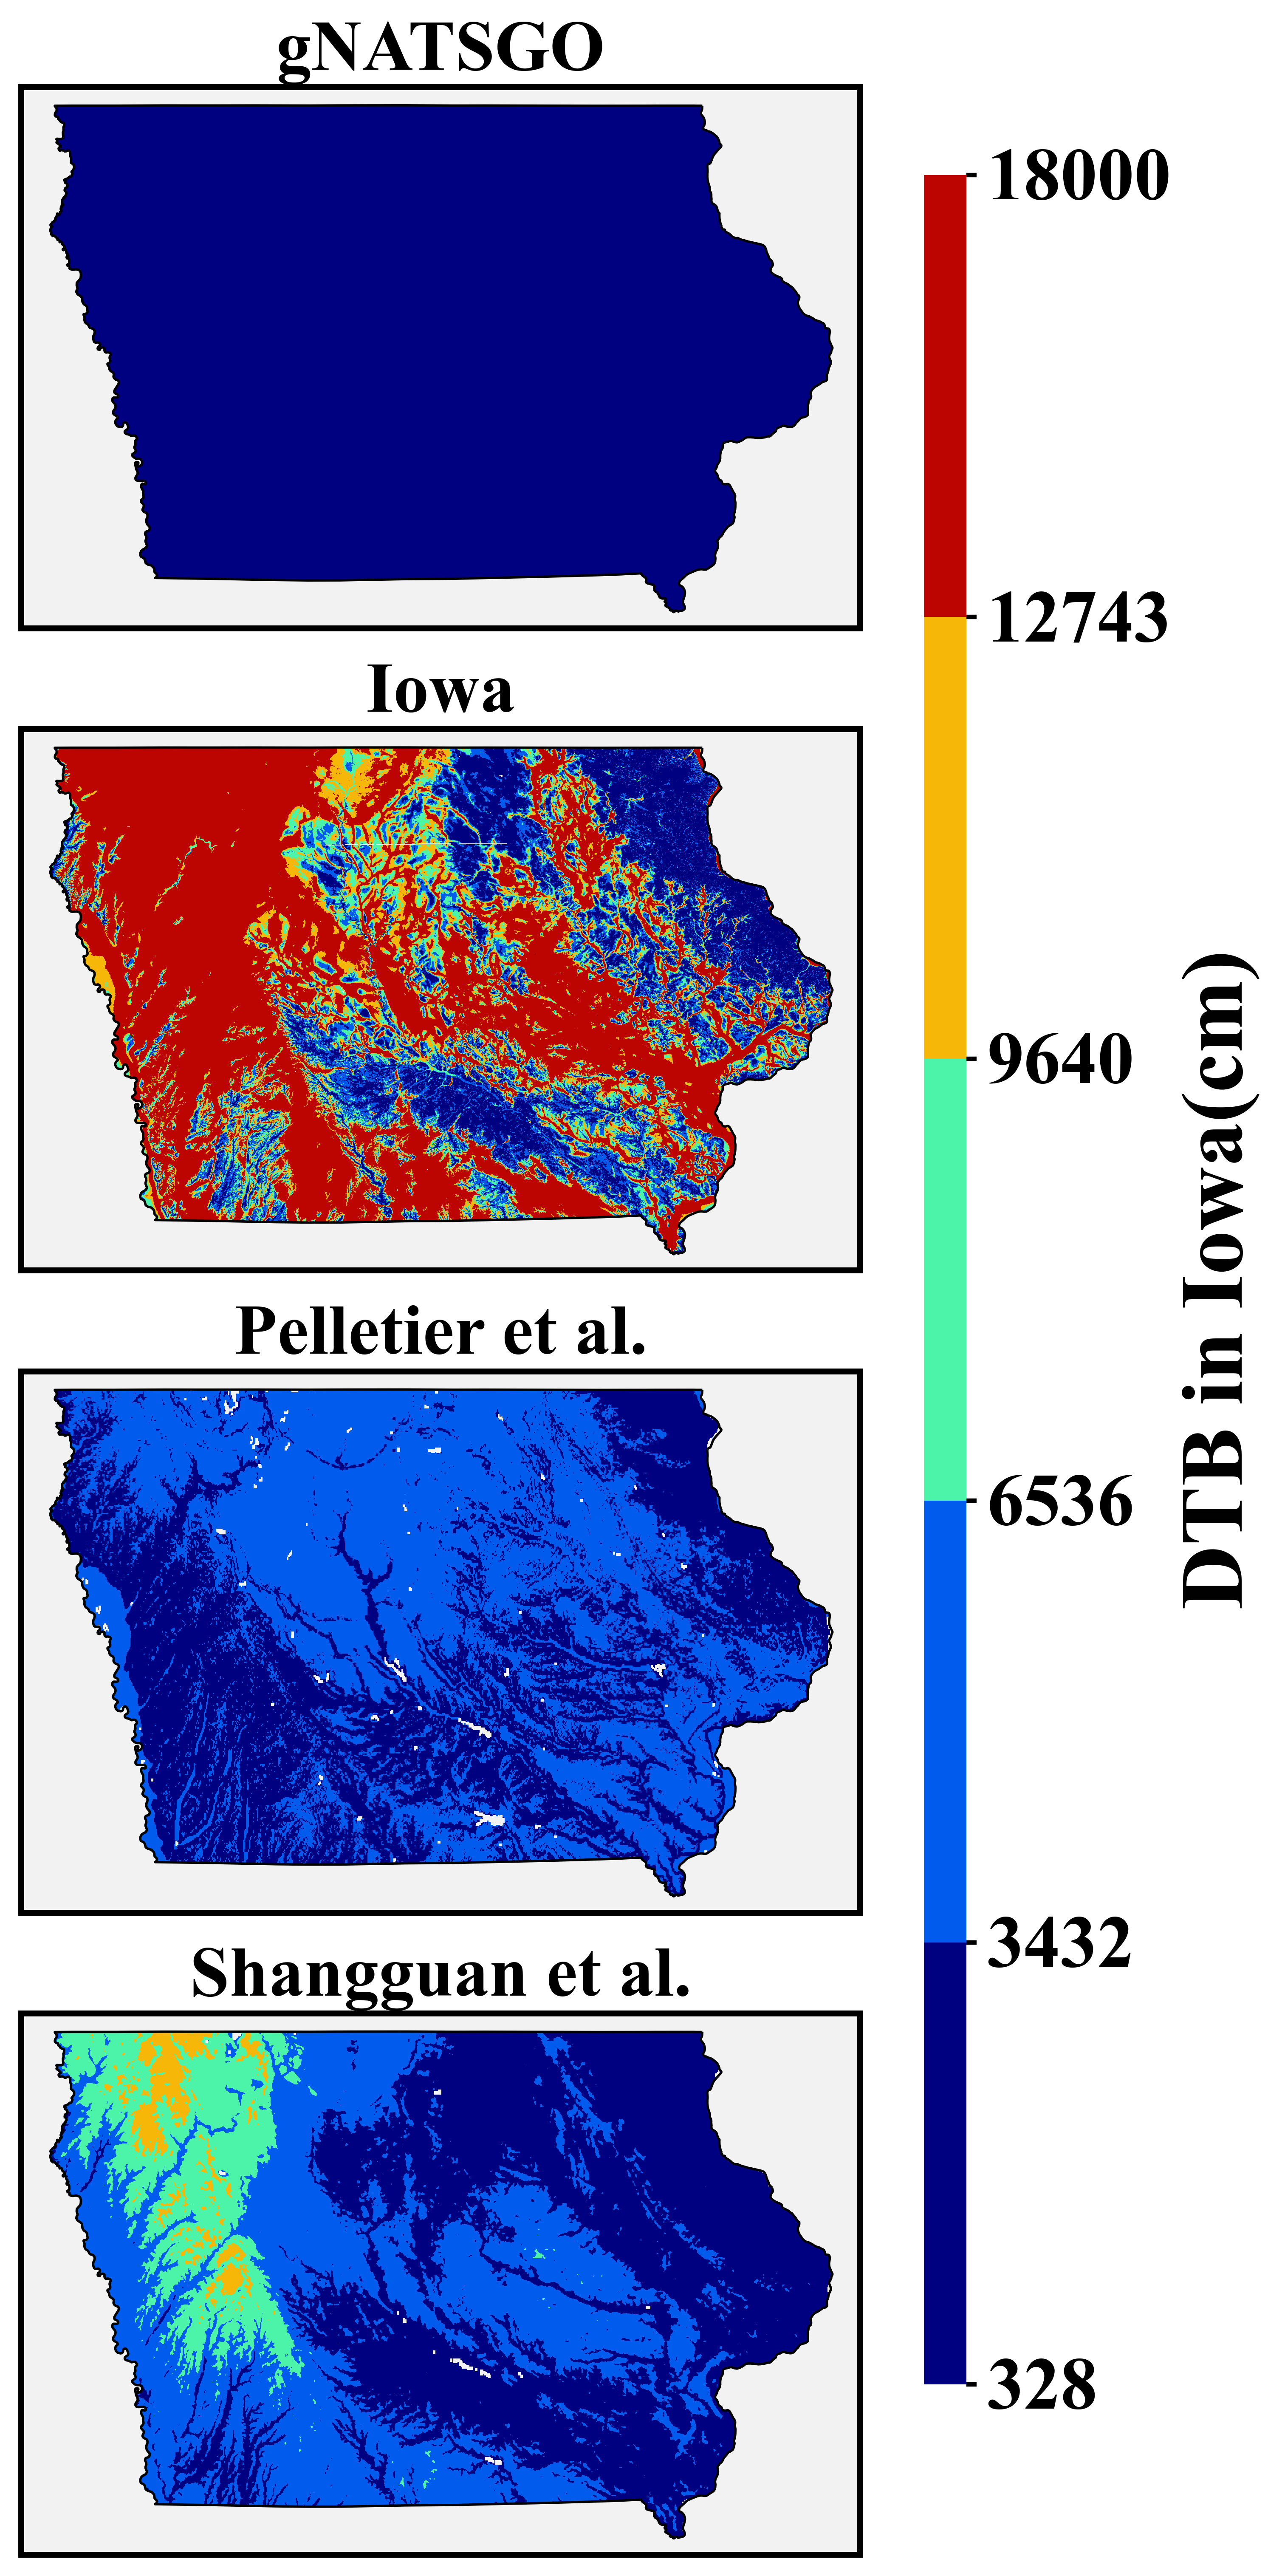

In [ ]:
%matplotlib inline

import os
import cmaps
import salem
import numpy as np
import xarray as xr
import geopandas as gpd
from pylab import rcParams
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from myfunc import timer
from myfunc import DirMan
import config
import matplotlib.font_manager as fm

resolution     = config.resolution
region         = config.region
data_path      = config.data_path
post_data_path = config.post_data_path
shp_path       = config.shp_path
fig_path       = config.fig_path

print('python draw_c1_DTB.py')

font = {'family': 'Times New Roman'}
matplotlib.rc('font', **font)

params = {'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

path = '/tera11/zhwei/students/Xionghui/data/DTB/'

shp = gpd.read_file(shp_path+'US/States/Iowa.shp')

level = [328, 3432, 6536, 9640, 12743,18000]

RGBs =['#000180', '#015ced', '#4bf4a8', '#f7b708', '#bc0500']
cmap = colors.ListedColormap(RGBs)

font_properties = fm.FontProperties(weight='bold')

fig = plt.figure(figsize=(5, 13), dpi=500)
fig.subplots_adjust(left=0.05, right=0.84, 
                bottom=0.02, top=0.95, hspace=0, wspace=0.05) 
gs = GridSpec(4, 1)

test = xr.open_dataset(f'{post_data_path}DTB/Iowa/Iowa.nc')
lat = test['lat']
lon = test['lon']
xmin,xmax,ymin,ymax = lon.min(),lon.max(),lat.min(),lat.max()
teasd sd awd asdSdst.close()  opf
asd
def define_colormsdap(level, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    color = cmap(np.linspace(0, 1, len(level) - 1))
    cmap_custom = colors.ListedColormap(color)
    cmap_custom.set_under(cmap(0))
    cmap_custom.set_over(color[-1])
    norm = colors.BoundaryNorm(level, cmap_custom.N)
    return cmap_custom, norm

cmap, norm= define_colormap(level,cmap)

def plot(ax, s, name, xmin, xmax, ymin, ymax):
    s = np.ma.masked_where(np.isnan(s), s)  
    
    shp_fixed = shp.copy()
    shp_fixed['geometry'] = shp_fixed['geometry'].buffer(0)
    
    img = ax.imshow(s, cmap=cmap,
                    extent=[xmin, xmax, ymax, ymin],
                    norm = norm)
    
    bbox = gpd.GeoSeries([box(xmin, ymin, xmax, ymax)], crs=shp.crs)
    clipped_shapefile = gpd.clip(shp, bbox)
    clipped_shapefile.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=0.8)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(2)  

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(name,fontsize=24,fontweight='bold')
    
    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    # ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)

    ax.set_extent([xmin,xmax,ymin,ymax])
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    print('-------draw_finish----------')
    return img


def draw1():
    image = xr.open_dataset(f'{post_data_path}DTB/gNATSGO/Bedrock_US_gNATSGO_90m-2.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'gNATSGO'
    img = plot(fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

def draw2():
    image = xr.open_dataset(f'{post_data_path}DTB/Iowa/Iowa.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']*100
    s = s.salem.roi(shape=shp)
    name = 'Iowa'
    img = plot(fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

def draw3():
    image = xr.open_dataset(f'{post_data_path}mask1/mask1_v3/DTB_temp1.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'Pelletier et al.'
    img = plot(fig.add_subplot(gs[2, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img


def draw4():
    image = xr.open_dataset(f'{post_data_path}mask1/mask1_v1/DTB_temp2.nc').sel(lon=slice(xmin,xmax),lat=slice(ymin,ymax))
    s = image['Band1']
    s = s.salem.roi(shape=shp)
    name = 'Shangguan et al.'
    img = plot(fig.add_subplot(gs[3, :], projection=ccrs.PlateCarree()), s, name, xmin, xmax, ymin, ymax)
    return img

draw1()
draw2()
draw3()
img = draw4()

rect = [0.9, 0.1, 0.04, 0.8]  #左下角x,y,宽,高
cbar_ax = fig.add_axes(rect,frameon = False)
cb = fig.colorbar(img, 
                drawedges=False,
                ticks=level, 
                cax=cbar_ax, 
                orientation='vertical',
                spacing='uniform')

cb.ax.tick_params(labelsize=20)
cb.ax.yaxis.set_tick_params(direction='out', width=1.5)
for label in cb.ax.get_xticklabels() + cb.ax.get_yticklabels():
    label.set_fontproperties(font_properties)
cb.set_label(f"DTB in Iowa(cm)", fontsize=30, fontweight='bold')

# plt.tight_layout()
# plt.savefig(f"{fig_path}/c1_DTB.png")
plt.show()